# 3.6 Implementing a Logistic Regression Classifier (Part 3)

## 1) Installing Libraries

In [1]:
# !conda install numpy pandas matplotlib --yes

In [2]:
# !pip install torch torchvision torchaudio

In [3]:
# !conda install watermark

In [4]:
%load_ext watermark
%watermark -v -p numpy,pandas,matplotlib,torch

Python implementation: CPython
Python version       : 3.11.9
IPython version      : 8.31.0

numpy     : 2.2.1
pandas    : 2.2.3
matplotlib: 3.10.0
torch     : 2.5.1



## 2) Loading the Dataset

In [5]:
import pandas as pd

df = pd.read_csv("perceptron_toydata-truncated.txt", sep="\t")
df

,x1,x2,label
0,0.77,-1.14,0
1,-0.33,1.44,0
2,0.91,-3.07,0
3,-0.37,-1.91,0
4,-0.63,-1.53,0
5,0.39,-1.99,0
6,-0.49,-2.74,0
7,-0.68,-1.52,0
8,-0.10,-3.43,0
9,-0.05,-1.95,0


In [6]:
X_train = df[["x1", "x2"]].values
y_train = df["label"].values

In [7]:
X_train

array([[ 0.77, -1.14],
       [-0.33,  1.44],
       [ 0.91, -3.07],
       [-0.37, -1.91],
       [-0.63, -1.53],
       [ 0.39, -1.99],
       [-0.49, -2.74],
       [-0.68, -1.52],
       [-0.1 , -3.43],
       [-0.05, -1.95],
       [ 3.88,  0.65],
       [ 0.73,  2.97],
       [ 0.83,  3.94],
       [ 1.59,  1.25],
       [ 1.14,  3.91],
       [ 1.73,  2.8 ],
       [ 1.31,  1.85],
       [ 1.56,  3.85],
       [ 1.23,  2.54],
       [ 1.33,  2.03]])

In [8]:
X_train.shape

(20, 2)

In [9]:
y_train

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [10]:
y_train.shape

(20,)

In [11]:
import numpy as np

np.bincount(y_train)

array([10, 10])

## 3) Visualizing the dataset

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt

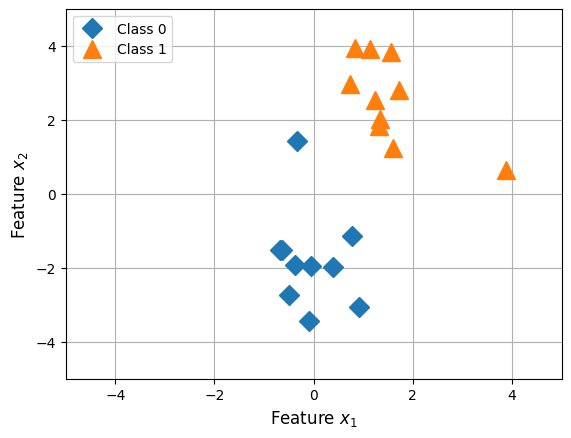

In [13]:
plt.plot(
    X_train[y_train == 0, 0],
    X_train[y_train == 0, 1],
    marker="D",
    markersize=10,
    linestyle="",
    label="Class 0",
)

plt.plot(
    X_train[y_train == 1, 0],
    X_train[y_train == 1, 1],
    marker="^",
    markersize=13,
    linestyle="",
    label="Class 1",
)

plt.legend(loc=2)

plt.xlim([-5, 5])
plt.ylim([-5, 5])

plt.xlabel("Feature $x_1$", fontsize=12)
plt.ylabel("Feature $x_2$", fontsize=12)

plt.grid()
plt.show()

In [14]:
X_train = (X_train - X_train.mean(axis=0)) / X_train.std(axis=0)

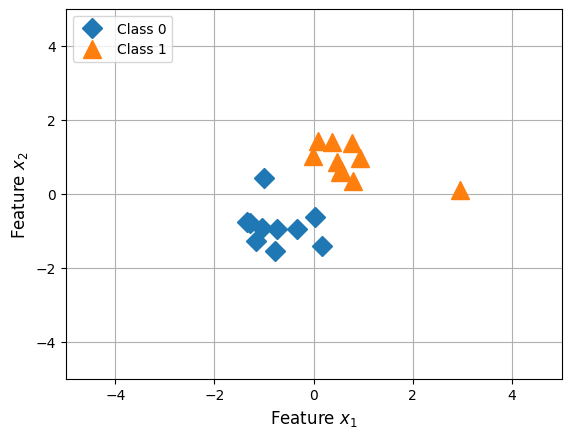

In [15]:
plt.plot(
    X_train[y_train == 0, 0],
    X_train[y_train == 0, 1],
    marker="D",
    markersize=10,
    linestyle="",
    label="Class 0",
)

plt.plot(
    X_train[y_train == 1, 0],
    X_train[y_train == 1, 1],
    marker="^",
    markersize=13,
    linestyle="",
    label="Class 1",
)

plt.legend(loc=2)

plt.xlim([-5, 5])
plt.ylim([-5, 5])

plt.xlabel("Feature $x_1$", fontsize=12)
plt.ylabel("Feature $x_2$", fontsize=12)

plt.grid()
plt.show()

## 4) Implementing the model

In [16]:
import torch

class LogisticRegression(torch.nn.Module):
    
    def __init__(self, num_features):
        super().__init__()
        self.linear = torch.nn.Linear(num_features, 1)
    
    def forward(self, x):
        logits = self.linear(x)
        probas = torch.sigmoid(logits)
        return probas

In [17]:
torch.manual_seed(1)

model = LogisticRegression(num_features=2)

In [18]:
x = torch.tensor([1.1, 2.1])

with torch.no_grad():
    proba = model(x)
    
print(proba)

tensor([0.4033])


## 5) Defining a DataLoader

In [19]:
from torch.utils.data import Dataset, DataLoader


class MyDataset(Dataset):
    def __init__(self, X, y):

        self.features = torch.tensor(X, dtype=torch.float32)
        self.labels = torch.tensor(y, dtype=torch.float32)

    def __getitem__(self, index):
        x = self.features[index]
        y = self.labels[index]        
        return x, y

    def __len__(self):
        return self.labels.shape[0]
    

train_ds = MyDataset(X_train, y_train)

train_loader = DataLoader(
    dataset=train_ds,
    batch_size=10,
    shuffle=True,
)

In [20]:
X_train.shape

(20, 2)

## 6) The training loop

In [21]:
import torch.nn.functional as F


torch.manual_seed(1)
model = LogisticRegression(num_features=2)
optimizer = torch.optim.SGD(model.parameters(), lr=0.05)

num_epochs = 20

for epoch in range(num_epochs):
    
    model = model.train()
    for batch_idx, (features, class_labels) in enumerate(train_loader):

        probas = model(features)
        
        loss = F.binary_cross_entropy(probas, class_labels.view(probas.shape))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        ### LOGGING
        print(f'Epoch: {epoch+1:03d}/{num_epochs:03d}'
               f' | Batch {batch_idx:03d}/{len(train_loader):03d}'
               f' | Loss: {loss:.2f}')
            

Epoch: 001/020 | Batch 000/002 | Loss: 0.67
Epoch: 001/020 | Batch 001/002 | Loss: 0.73
Epoch: 002/020 | Batch 000/002 | Loss: 0.67
Epoch: 002/020 | Batch 001/002 | Loss: 0.67
Epoch: 003/020 | Batch 000/002 | Loss: 0.60
Epoch: 003/020 | Batch 001/002 | Loss: 0.68
Epoch: 004/020 | Batch 000/002 | Loss: 0.69
Epoch: 004/020 | Batch 001/002 | Loss: 0.54
Epoch: 005/020 | Batch 000/002 | Loss: 0.61
Epoch: 005/020 | Batch 001/002 | Loss: 0.57
Epoch: 006/020 | Batch 000/002 | Loss: 0.59
Epoch: 006/020 | Batch 001/002 | Loss: 0.54
Epoch: 007/020 | Batch 000/002 | Loss: 0.51
Epoch: 007/020 | Batch 001/002 | Loss: 0.58
Epoch: 008/020 | Batch 000/002 | Loss: 0.51
Epoch: 008/020 | Batch 001/002 | Loss: 0.54
Epoch: 009/020 | Batch 000/002 | Loss: 0.51
Epoch: 009/020 | Batch 001/002 | Loss: 0.49
Epoch: 010/020 | Batch 000/002 | Loss: 0.53
Epoch: 010/020 | Batch 001/002 | Loss: 0.44
Epoch: 011/020 | Batch 000/002 | Loss: 0.42
Epoch: 011/020 | Batch 001/002 | Loss: 0.52
Epoch: 012/020 | Batch 000/002 |

## 7) Evaluating the results

In [22]:
probas

tensor([[0.6687],
        [0.6810],
        [0.2162],
        [0.7398],
        [0.2126],
        [0.5744],
        [0.3209],
        [0.6503],
        [0.4276],
        [0.2598]], grad_fn=<SigmoidBackward0>)

In [23]:
pred = torch.where(probas > 0.5, 1, 0)
pred

tensor([[1],
        [1],
        [0],
        [1],
        [0],
        [1],
        [0],
        [1],
        [0],
        [0]])

In [24]:
class_labels.view(pred.shape).to(pred.dtype)

tensor([[1],
        [1],
        [0],
        [1],
        [0],
        [1],
        [0],
        [1],
        [0],
        [0]])

In [25]:
def compute_accuracy(model, dataloader):

    model = model.eval()
    
    correct = 0.0
    total_examples = 0
    
    for idx, (features, class_labels) in enumerate(dataloader):
        
        with torch.no_grad():
            probas = model(features)
        
        pred = torch.where(probas > 0.5, 1, 0)
        lab = class_labels.view(pred.shape).to(pred.dtype)

        compare = lab == pred
        correct += torch.sum(compare)
        total_examples += len(compare)

    return correct / total_examples

In [31]:
train_acc = compute_accuracy(model, train_loader)

In [32]:
print(f"Accuracy: {train_acc*100}%")

Accuracy: 100.0%


## 8) Optional: visualizing the decision boundary

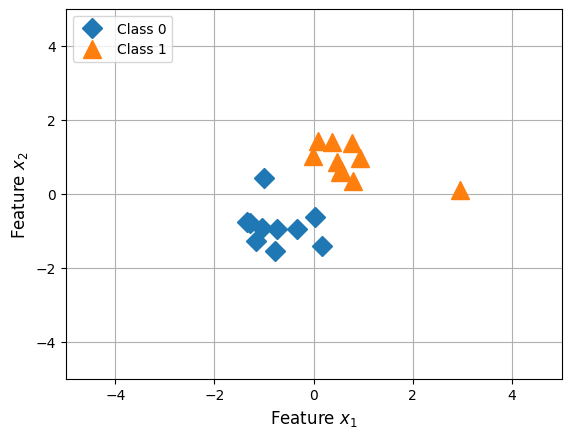

In [33]:
plt.plot(
    X_train[y_train == 0, 0],
    X_train[y_train == 0, 1],
    marker="D",
    markersize=10,
    linestyle="",
    label="Class 0",
)

plt.plot(
    X_train[y_train == 1, 0],
    X_train[y_train == 1, 1],
    marker="^",
    markersize=13,
    linestyle="",
    label="Class 1",
)

plt.legend(loc=2)

plt.xlim([-5, 5])
plt.ylim([-5, 5])

plt.xlabel("Feature $x_1$", fontsize=12)
plt.ylabel("Feature $x_2$", fontsize=12)

plt.grid()
plt.show()

In [34]:
def plot_boundary(model):

    w1 = model.linear.weight[0][0].detach()
    w2 = model.linear.weight[0][1].detach()
    b = model.linear.bias[0].detach()

    x1_min = -20
    x2_min = (-(w1 * x1_min) - b) / w2

    x1_max = 20
    x2_max = (-(w1 * x1_max) - b) / w2

    return x1_min, x1_max, x2_min, x2_max

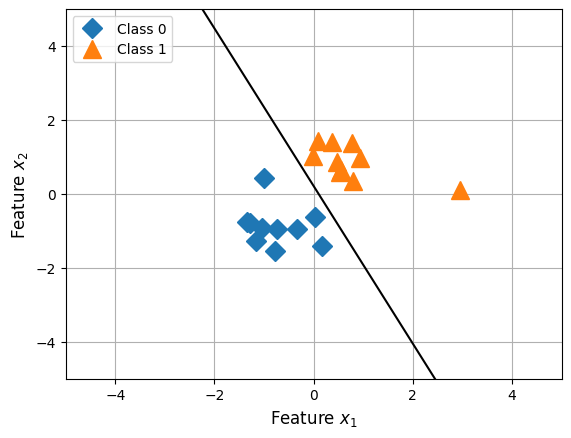

In [35]:
x1_min, x1_max, x2_min, x2_max = plot_boundary(model)


plt.plot(
    X_train[y_train == 0, 0],
    X_train[y_train == 0, 1],
    marker="D",
    markersize=10,
    linestyle="",
    label="Class 0",
)

plt.plot(
    X_train[y_train == 1, 0],
    X_train[y_train == 1, 1],
    marker="^",
    markersize=13,
    linestyle="",
    label="Class 1",
)

plt.plot([x1_min, x1_max], [x2_min, x2_max], color="k")

plt.legend(loc=2)

plt.xlim([-5, 5])
plt.ylim([-5, 5])

plt.xlabel("Feature $x_1$", fontsize=12)
plt.ylabel("Feature $x_2$", fontsize=12)

plt.grid()
plt.show()